In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# See https://github.com/QuantCrimAtLeeds/PredictCode/
import open_cp.sources.sepp

In [3]:
source = open_cp.sources.sepp.GridHawkesProcess([[1]], 0.3, 1)
grid_data = source.sample(0, 100)
data = grid_data[0,0]

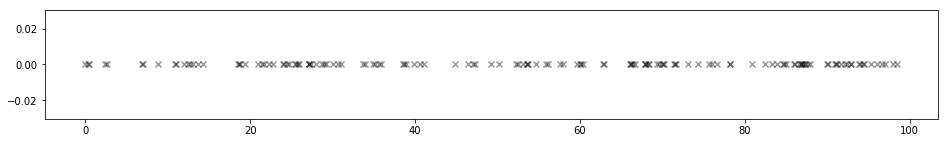

In [4]:
fig, ax = plt.subplots(figsize=(16,2))

ax.scatter(data, [0]*len(data), color="black", marker="x", alpha=0.4)

The intensity function is

$$ f(t) = \mu + \sum_{s < t} \theta \omega e^{-\omega (t-s)} $$

For us, $\mu=1, \theta=0.5, \omega=10$.

The likelihood, given $n$ the total number of observed events in $[0,T]$, is

$$ L = \prod_{i=1}^N f(t_i) \exp\Big(-\int_0^T f(t) \ dt \Big). $$

We compute the integral as
\begin{align*}
\int_0^T f(t) \ dt &= \int_0^T \mu \ dt + \int_{t_1}^T \theta\omega e^{-\omega(t-t_1)} \ dt
+ \int_{t_2}^T \theta\omega e^{-\omega(t-t_2)} \ dt + \cdots  \\
&= \mu T + \theta\sum_i\big(1-e^{-\omega (T-t_i)}\big)
\end{align*}

Thus
$$ \log L = \sum_i \log\Big( \mu + \sum_{j<i} \theta \omega e^{-\omega (t_i-t_j)} \Big)
- \mu T - \theta\sum_i\big(1-e^{-\omega (T-t_i)}\big)
$$

Let
$$ T_i = \sum_{j<i} \theta \omega e^{-\omega(t_i-t_j)}. $$
Then
$$ T_{i+1} = \theta \omega e^{-\omega(t_{i+1}-t_i)} + \sum_{j<i} \theta \omega e^{-\omega(t_{i+1}-t_i)} e^{-\omega(t_i-t_j)}
= e^{-\omega(t_{i+1}-t_i)} (\theta \omega + T_i) $$
which leads to an iterative scheme, with $T_1 = 0$

In [5]:
T = 100

def log_likelihood(mu, theta, omega, data, T=100):
    t = np.empty_like(data)
    t[0] = 0
    for i in range(1, len(data)):
        t[i] = np.exp(-omega*(data[i] - data[i-1])) * (theta * omega + t[i-1])
    return np.sum(np.log(mu + np.asarray(t))) - mu * T - theta * np.sum(1 - np.exp(omega*(data-T)))

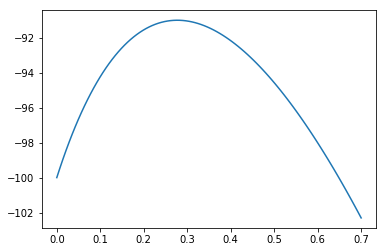

In [28]:
thetas = np.linspace(0, 0.7, 100)

ll = [log_likelihood(1, t, 1, data) for t in thetas]

plt.plot(thetas, ll)

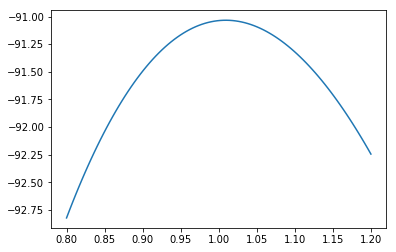

In [29]:
mus = np.linspace(0.8, 1.2, 100)

ll = [log_likelihood(m, 0.3, 1, data) for m in mus]

plt.plot(mus, ll)

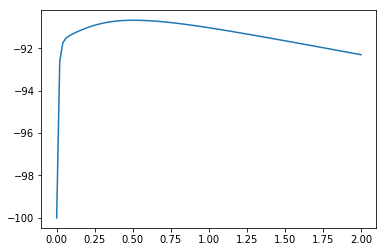

In [30]:
omegas = np.linspace(0, 2, 100)

ll = [log_likelihood(1, 0.3, w, data) for w in omegas]

plt.plot(omegas, ll)

## Priors

Let's use $\mu \sim \operatorname{Exp}(1)$, $\theta \sim \operatorname{Beta}(1,1)$ and $\omega \sim \operatorname{Exp}(1/10)$

In [18]:
def full_log_likelihood(x, data, T=100):
    mu, theta, omega = x
    if mu < 0 or omega < 0 or theta < 0 or theta >= 1:
        return -np.inf
    prior_ll = -mu -omega #+ np.log(0.1) - 0.1*omega 
    return prior_ll + log_likelihood(mu, theta, omega, data, T)

In [19]:
full_log_likelihood([1, 0.5, 2], data)

-100.21884457176805

In [20]:
import emcee

In [21]:
nwalkers = 50
p0 = np.random.rand(3 * nwalkers).reshape((nwalkers, 3))

In [22]:
sampler = emcee.EnsembleSampler(nwalkers, 3, full_log_likelihood, args=(data, 100))

In [23]:
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [24]:
_ = sampler.run_mcmc(pos, 2000)

In [25]:
import corner

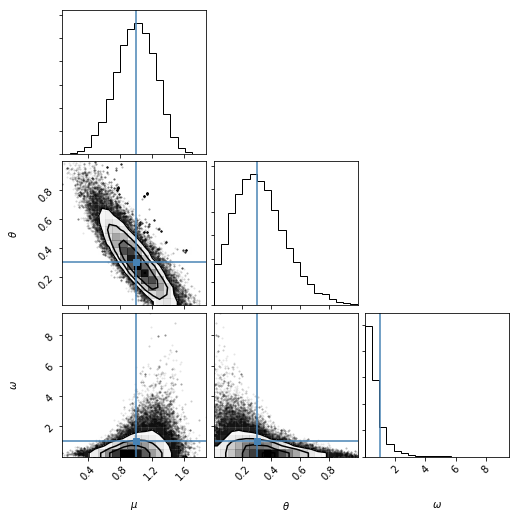

In [26]:
fig = corner.corner(sampler.flatchain, labels=["$\mu$", "$\\theta$", "$\omega$"], truths=[1,0.3,1])